<a href="https://colab.research.google.com/github/pradeepvaranasi/ecommerce_clv/blob/main/ecommerce_clv_lifetimes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


For this exercise, we’re going to predict future purchasing from a history of customer transactions.

Data represents approximately 50,000 transactions from an ecommerce store that sells widgets



In [ ]:
# installing lifetimes package
!pip install Lifetimes

**placeholder

In [48]:
# importing libraries
import pandas as pd
import numpy as np
import datetime as dt
from operator import attrgetter
from sklearn.cluster import KMeans
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.utils import calibration_and_holdout_data
from lifetimes.utils import summary_data_from_transaction_data
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases
from lifetimes.plotting import plot_period_transactions
from lifetimes.plotting import plot_frequency_recency_matrix, plot_probability_alive_matrix
from sklearn.metrics import (silhouette_score,
                             calinski_harabasz_score,
                             davies_bouldin_score, mean_squared_error)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [5]:
# importing data
data = pd.read_csv('data.csv')

In [6]:
# copying the data to dataframe df
df = data.copy()

In [7]:
# checking the first n rows
df.head(2)

,CustomerID,Timestamp,PurchaseValue
0,5611860a94204a4078659f1667372cc4,2017-02-09T18:31:00Z,4.72
1,07b260307114f9cffc5601eb7ad4b565,2017-06-28T19:26:00Z,5.33


In [8]:
# checking the shape of the dataframe
df.shape

(49945, 3)

In [9]:
# checking for duplicates
df.duplicated().sum()

0

In [10]:
# Explore basic characteristics of the data
print("Basic Data Information:")
df.info()

Basic Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49945 entries, 0 to 49944
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CustomerID     49945 non-null  object 
 1   Timestamp      49945 non-null  object 
 2   PurchaseValue  49945 non-null  float64
dtypes: float64(1), object(2)
memory usage: 1.1+ MB


From the above, we could infer
1. There are no missing values in the data
2. There are no duplicate values in the data
3. The *Timestamp* feature should be coverted to datetime object

In [11]:
# reconfirming the missing values in the data
df.isnull().sum()

CustomerID       0
Timestamp        0
PurchaseValue    0
dtype: int64

In [12]:
# Timestamp feature conversion to datatime object
df['Timestamp'] = pd.to_datetime(df['Timestamp']).dt.date
df.head(2)

,CustomerID,Timestamp,PurchaseValue
0,5611860a94204a4078659f1667372cc4,2017-02-09,4.72
1,07b260307114f9cffc5601eb7ad4b565,2017-06-28,5.33


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49945 entries, 0 to 49944
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CustomerID     49945 non-null  object 
 1   Timestamp      49945 non-null  object 
 2   PurchaseValue  49945 non-null  float64
dtypes: float64(1), object(2)
memory usage: 1.1+ MB


In [14]:
# descriptive stats for the PurchaseValue feature
df['PurchaseValue'].describe()

count    49945.000000
mean       236.888196
std        245.760987
min          4.720000
25%         97.100000
50%        166.660000
75%        286.790000
max      11599.680000
Name: PurchaseValue, dtype: float64

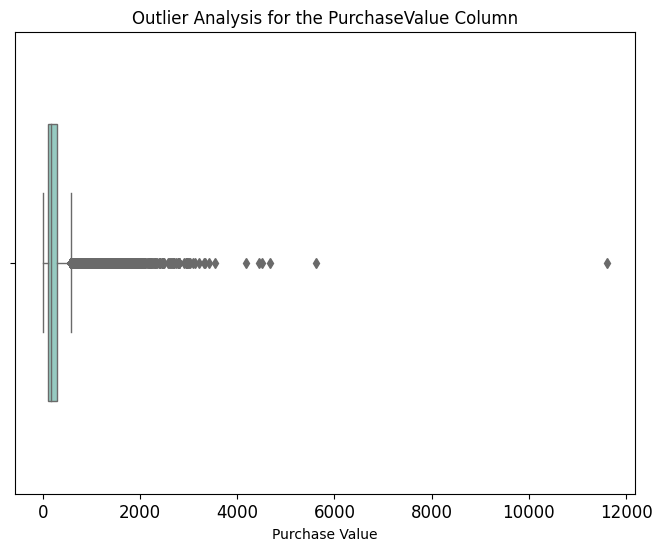

In [15]:
# Create a boxplot
plt.figure(figsize=(8, 6))  # Adjust the figure size

# Customize the color palette for better visibility
sns.set_palette("Set3")

# Increase the linewidth of the box and whiskers
sns.boxplot(x=df['PurchaseValue'], linewidth=1, width=0.6)

# Set labels and title
plt.xlabel('Purchase Value')
plt.title('Outlier Analysis for the PurchaseValue Column')

# Customize tick labels for better readability
plt.xticks(fontsize=12)

# Show the plot
plt.show()

In [16]:
df.head(2)

,CustomerID,Timestamp,PurchaseValue
0,5611860a94204a4078659f1667372cc4,2017-02-09,4.72
1,07b260307114f9cffc5601eb7ad4b565,2017-06-28,5.33


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49945 entries, 0 to 49944
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CustomerID     49945 non-null  object 
 1   Timestamp      49945 non-null  object 
 2   PurchaseValue  49945 non-null  float64
dtypes: float64(1), object(2)
memory usage: 1.1+ MB


In [18]:
df['Timestamp'].max()

datetime.date(2017, 12, 6)

In [57]:
df['Timestamp'].min()

datetime.date(2016, 11, 30)

In [39]:
diff_time = df['Timestamp'].max() - df['Timestamp'].min()
diff_time

datetime.timedelta(days=371)

In [41]:
df_rfmt = summary_data_from_transaction_data(transactions = df,
                                         customer_id_col = 'CustomerID',
                                         datetime_col = 'Timestamp',
                                         monetary_value_col = 'PurchaseValue')

df_rfmt = df_rfmt.reset_index()
df_rfmt.head()

,CustomerID,frequency,recency,T,monetary_value
0,0001117ff1305c1fe840697166e61564,1.0,11.0,344.0,87.280
1,00028502859fd7e111d88c20456b59d5,0.0,0.0,342.0,0.000
2,000306d200fd6e9b03de48d15348f5c2,0.0,0.0,33.0,0.000
3,0003f3458a6e7b495a975c2d9ddda559,2.0,285.0,343.0,88.065
4,000784b838b807ad589d4bc69c0c562f,0.0,0.0,210.0,0.000


In [74]:
# Getting the ending date of the calibration period.
end_date_cal = df['Timestamp'].min() + dt.timedelta(days=270)
end_date_obs = end_date_cal + (diff_time - dt.timedelta(days=270))

In [75]:
print(end_date_cal)
print(end_date_obs)

2017-08-27
2017-12-06


In [76]:
df_rfmt_cal = calibration_and_holdout_data(transactions=df,
                                          customer_id_col="CustomerID",
                                          datetime_col = "Timestamp",
                                          calibration_period_end=end_date_cal,
                                          observation_period_end= end_date_obs)
df_rfmt_cal.head()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
CustomerID,,,,,
0001117ff1305c1fe840697166e61564,1.0,11.0,243.0,0.0,101.0
00028502859fd7e111d88c20456b59d5,0.0,0.0,241.0,0.0,101.0
0003f3458a6e7b495a975c2d9ddda559,1.0,2.0,242.0,1.0,101.0
000784b838b807ad589d4bc69c0c562f,0.0,0.0,109.0,0.0,101.0
000ad0f90e9fcb6ff5a0bc480cccbdb3,5.0,68.0,99.0,0.0,101.0


In [77]:
import warnings
warnings.filterwarnings("ignore")
l2_coefs = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.1, 0.2, 0.3, 0.4, 0.5]
l2_list = []
rmse_list = []
for coef in l2_coefs :
    # Fitting the model using the calibration dataset.
    model = BetaGeoFitter(penalizer_coef=coef)
    model.fit(df_rfmt_cal['frequency_cal'],
        df_rfmt_cal['recency_cal'],
        df_rfmt_cal['T_cal'])
    # Predicting the frequency for the holdout period for all customers.
    pred_freq = pd.DataFrame(model.predict(df_rfmt_cal['duration_holdout'],
                                 df_rfmt_cal['frequency_cal'], df_rfmt_cal['recency_cal'], df_rfmt_cal['T_cal']), columns=['pred_frequency']).reset_index()
    # Merging the two dataframes and dropping NaN values.
    new_df = df_rfmt_cal.reset_index().merge(pred_freq, on='CustomerID').dropna()

    # Computing the rmse score
    rmse_score = np.sqrt(mean_squared_error(new_df['frequency_holdout'],new_df['pred_frequency']))
    l2_list.append(coef)
    rmse_list.append(rmse_score)

# Getting the results
resl = pd.DataFrame(np.array(rmse_list), columns=['rmse_score'])\
             .merge(pd.DataFrame(np.array(l2_list), columns=['L2 coefs']), right_index=True, left_index=True)
resl

,rmse_score,L2 coefs
0,0.858029,0.01
1,0.854650,0.02
2,0.858502,0.03
3,0.862267,0.04
4,0.865502,0.05
5,0.868397,0.06
6,0.877873,0.10
7,0.894431,0.20
8,0.906298,0.30
9,0.915728,0.40


In [88]:
# Fitting the model using the calibration dataset.
model = BetaGeoFitter(penalizer_coef=0.02)
model.fit(df_rfmt_cal['frequency_cal'],
        df_rfmt_cal['recency_cal'],
        df_rfmt_cal['T_cal'])

<lifetimes.BetaGeoFitter: fitted with 18545 subjects, a: 0.13, alpha: 49.33, b: 0.39, r: 0.37>

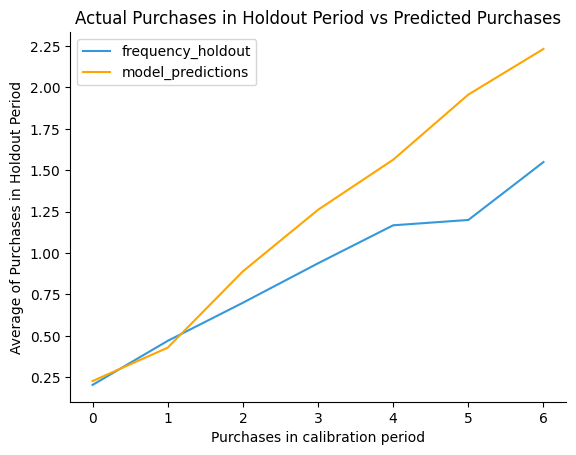

In [89]:
# Plotting the calibration vs. holdout purchases
import warnings
warnings.filterwarnings("ignore")

custom_palette = ['#3498db', '#85c1e9']  # Dark blue and light blue

# Plot the calibration vs. holdout purchases with custom colors
plot_calibration_purchases_vs_holdout_purchases(model, df_rfmt_cal, kind='frequency_cal', color=['#3498db','#FFA500'])
sns.despine();

In [90]:
# Predicting the number of purchases in the next 180 days for all customers.
df_rfmt['predicted_purchases'] = model.conditional_expected_number_of_purchases_up_to_time(365,
                                                                                      df_rfmt['frequency'],
                                                                                      df_rfmt['recency'],
                                                                                      df_rfmt['T'])
df_rfmt.dropna(inplace=True)
# Getting rid of negative values.
df_rfmt = df_rfmt[df_rfmt['monetary_value']>0]
df_rfmt.head()

,CustomerID,frequency,recency,T,monetary_value,predicted_purchases
0,0001117ff1305c1fe840697166e61564,1.0,11.0,344.0,87.280,0.216240
3,0003f3458a6e7b495a975c2d9ddda559,2.0,285.0,343.0,88.065,1.819585
5,0008e6b90a8f191089e8a0757fabf968,1.0,69.0,77.0,145.540,2.484406
6,00090b9fa28029c4839ca0a0306b6b11,1.0,61.0,82.0,349.440,2.296965
7,000ad0f90e9fcb6ff5a0bc480cccbdb3,5.0,68.0,200.0,229.782,2.647462


In [91]:
# Fitting the GammaGamma model

gg_model = GammaGammaFitter()
gg_model.fit(df_rfmt['frequency'], df_rfmt['monetary_value'])

<lifetimes.GammaGammaFitter: fitted with 9647 subjects, p: 4.57, q: 3.65, v: 135.88>

In [95]:
df_rfmt['pred_monetary'] = gg_model.conditional_expected_average_profit(
        df_rfmt['frequency'],
        df_rfmt['monetary_value'])
df_rfmt.head()

,CustomerID,frequency,recency,T,monetary_value,predicted_purchases,pred_monetary
0,0001117ff1305c1fe840697166e61564,1.0,11.0,344.0,87.280,0.216240,141.244656
3,0003f3458a6e7b495a975c2d9ddda559,2.0,285.0,343.0,88.065,1.819585,120.936351
5,0008e6b90a8f191089e8a0757fabf968,1.0,69.0,77.0,145.540,2.484406,178.118958
6,00090b9fa28029c4839ca0a0306b6b11,1.0,61.0,82.0,349.440,2.296965,307.172688
7,000ad0f90e9fcb6ff5a0bc480cccbdb3,5.0,68.0,200.0,229.782,2.647462,230.250884


In [97]:
# Predicting the CLV.
df_rfmt['CLV'] = gg_model.customer_lifetime_value(
    model,
    df_rfmt['frequency'],
    df_rfmt['recency'],
    df_rfmt['T'],
    df_rfmt['monetary_value'],
    time = 12,# In months
    )
df_rfmt.head()

,CustomerID,frequency,recency,T,monetary_value,predicted_purchases,pred_monetary,CLV
0,0001117ff1305c1fe840697166e61564,1.0,11.0,344.0,87.280,0.216240,141.244656,28.309033
3,0003f3458a6e7b495a975c2d9ddda559,2.0,285.0,343.0,88.065,1.819585,120.936351,203.915585
5,0008e6b90a8f191089e8a0757fabf968,1.0,69.0,77.0,145.540,2.484406,178.118958,410.755758
6,00090b9fa28029c4839ca0a0306b6b11,1.0,61.0,82.0,349.440,2.296965,307.172688,654.887102
7,000ad0f90e9fcb6ff5a0bc480cccbdb3,5.0,68.0,200.0,229.782,2.647462,230.250884,565.051951


#### Approach-2 (unused)


In [81]:
# # Create rfm data for Lifetimes
# max_date = df['Timestamp'].max()

# rfm = df.groupby('CustomerID').agg({'Timestamp': lambda x: (max_date - x.max()).days,
#                                     'CustomerID': lambda x: x.count(),
#                                     'PurchaseValue': lambda x: x.sum()})

# rfm.columns = ['recency', 'frequency', 'monetary']
# rfm = rfm.reset_index()
# rfm.head()

###### Building CLTV

In [82]:
# # calculate the cltv for the base data

# cltv_df = df.groupby("CustomerID").agg(
#     {
#         "Timestamp": [
#             lambda x: (x.max() - x.min()).days,
#             lambda x: (max_date - x.min()).days,
#         ],
#         "CustomerID": "count",
#         "PurchaseValue": "sum",
#     }
# )

# cltv_df.columns = cltv_df.columns.droplevel(0)
# cltv_df.columns = ["recency", "T", "frequency", "monetary"]
# cltv_df = cltv_df.reset_index()
# cltv_df.head()

In [83]:
# #Average Order Value
# cltv_df["monetary"] = cltv_df["monetary"] / cltv_df["frequency"]

# #Recency & Tenure
# cltv_df["recency"] = cltv_df["recency"] / 7
# cltv_df["T"] = cltv_df["T"] / 7

# #Frequency
# cltv_df = cltv_df[(cltv_df['frequency'] > 1)]

In [84]:
# cltv_df.shape

###### Model Building

In [85]:
# BGF = BetaGeoFitter(penalizer_coef=0.001)  # avoid overfitting

# BGF.fit(cltv_df["frequency"], cltv_df["recency"], cltv_df["T"])

###### 1 week test

In [86]:
# BGF.conditional_expected_number_of_purchases_up_to_time(
#     1, cltv_df["frequency"], cltv_df["recency"], cltv_df["T"]
# ).sort_values(ascending=False).head(10).to_frame(
#     "Expected Number of Transactions"
# ).reset_index()

###### Evaluation

In [87]:
# import seaborn as sns
# from lifetimes.plotting import plot_period_transactions
# from matplotlib.ticker import ScalarFormatter

# # plotting BetaGeoFitter model
# ax = plot_period_transactions(BGF, max_frequency=7, figsize=(10, 6),  color=['#3498db', '#85c1e9', '#ccd1d1'])
# ax.set_yscale('log')

# # # defining y-axis ticks and labels
# # ax.set_yticks([1, 2, 5, 10, 20, 50, 100, 200])
# # ax.get_yaxis().set_major_formatter(ScalarFormatter())

# # setting labels and title
# ax.set_xlabel('Number of Repeat Transactions')
# ax.set_ylabel('Number of Customers (log scale)')
# ax.set_title('Actual vs. Predicted Repeat Transactions')

# sns.despine();